In [22]:
#Visualize the resulting average system delay in function of the arrival rate (notebook version)
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import itertools as it
import configparser

In [34]:
#Constants
TRANSMISSION_RATE_A = 30000000 #(in bits/s)
TRANSMISSION_RATE_B = 20000000 #(in bits/s)
TRANSMISSION_RATE_C = 10000000 #(in bits/s)
PKT_SIZE = 1500 * 8 #(in bits)

A = 64
B = 1500
Q_LIMIT = 100

#Simulator inputs
SERVICE_TIME_A = PKT_SIZE / TRANSMISSION_RATE_A
SERVICE_TIME_B = PKT_SIZE / TRANSMISSION_RATE_B
SERVICE_TIME_C = PKT_SIZE / TRANSMISSION_RATE_C
INTERARRIVAL_TIMES = [1/x for x in range(1000, 4000, 100)]  #np.linspace(0.000401, 0.001, num=50) #[0.00045, 0.0005, 0.00055]

N = 10000
SEEDS = [1,2,3,4,5]

seed:  1
x:  [1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0000000000002, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0, 2500.0, 2600.0, 2700.0, 2800.0, 2900.0, 3000.0, 3100.0, 3200.0, 3300.0, 3400.0000000000005, 3499.9999999999995, 3600.0, 3700.0, 3800.0, 3900.0]
y:  [192.336, 192.532, 192.648, 192.725, 192.784, 192.841, 192.875, 192.93, 192.955, 192.96, 192.99, 193.014, 193.05, 193.055, 193.073, 193.079, 193.081, 193.11, 193.115, 193.115, 193.116, 193.134, 193.134, 193.135, 193.139, 193.14, 193.14, 193.14, 193.141, 193.141]

seed:  2
x:  [1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0000000000002, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0, 2500.0, 2600.0, 2700.0, 2800.0, 2900.0, 3000.0, 3100.0, 3200.0, 3300.0, 3400.0000000000005, 3499.9999999999995, 3600.0, 3700.0, 3800.0, 3900.0]
y:  [192.423, 192.536, 192.619, 192.708, 192.79, 192.881, 192.909, 192.965, 192.995, 193.025, 193.055, 193.079, 193.085, 193.114, 193.12, 193.139, 193.1

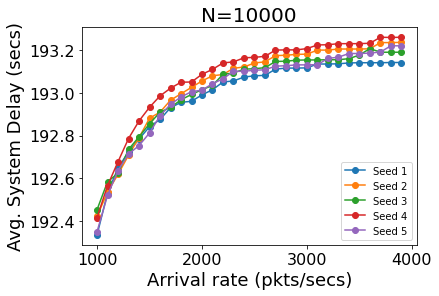

In [40]:
#Prepare plot
fig, ax = plt.subplots()
ax.set_xlabel("Arrival rate (pkts/secs)", fontsize=18)
ax.set_ylabel(f"Avg. System Delay (secs)", fontsize=18)
ax.set_title(f"N={N}", fontsize=20)
ax.tick_params(axis='x', which='both', labelsize=16)
ax.tick_params(axis='y', which='both', labelsize=16)    
ax.ticklabel_format(useOffset=False)

#Read config file
config = configparser.ConfigParser()
config.optionxform = str #to preserve case
config.read("input.txt")

#Fixed parameters
config.set('SYSTEM', 'mean_service_time_A', str(SERVICE_TIME_A))
config.set('SYSTEM', 'mean_service_time_B', str(SERVICE_TIME_B))
config.set('SYSTEM', 'mean_service_time_C', str(SERVICE_TIME_C))
config.set('SYSTEM', 'num_pkts', str(N))

for seed in SEEDS:
    print("seed: ", seed)
    system_delays = []
    x = list(map(lambda x:1/x, INTERARRIVAL_TIMES)) #1/x because we plot in function of the arrival rate
    
    for interarrival_time in INTERARRIVAL_TIMES:
        #Modify config file with given parameters
        config.set('SYSTEM', 'mean_interarrival_time', str(interarrival_time))
        config.set('SYSTEM', 'seed', str(seed))

        with open("input.txt", "w") as f:
            config.write(f, space_around_delimiters=False) #important to avoid breaking my c++ parser

        #run simulation (suppressing output)
        p = subprocess.run(["./main"], stdout=subprocess.DEVNULL)

        #Retrieve avg. system delay
        with open("output.txt", "r") as f:
            sd_line = f.read()
            system_delays.append(float(sd_line.rstrip()))
    
    #Plot
    ax.plot(x, system_delays, label=f"Seed {seed}", marker="o")
    ax.legend()

    print("x: ", x)
    print("y: ", system_delays)
    print("")